In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from util import *

import tensorflow as tf
import gym

from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Load our custom gym

In [ ]:
from gym.envs.registration import register

register(
    id='blob2d-v1',
    entry_point='blob_env.envs.blob_env:BlobEnv')

# Set our hyperparams

In [ ]:
env_name='blob2d-v1' # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 10000  # @param {type:"integer"} 
collect_steps_per_iteration = 1000  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -300  # @param {type:"integer"}
max_q_value = 25  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 100  # @param {type:"integer"}
eval_interval = 10000  # @param {type:"integer"}

# Create our environments

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))
eval_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))

# Set up our Categorical DQN Network

In [ ]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

# Metrics and Evaluation

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]
# Please also see the metrics module for standard implementations of different
# metrics.

## Metrics example
Show the avg return of a random policy

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Data collection

In [9]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


# Training

In [12]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 0.10143177211284637
step = 400: loss = 0.01126097235828638
step = 600: loss = 0.011471697129309177
step = 800: loss = 0.008756989613175392
step = 1000: loss = 0.0405343659222126
step = 1000: Average Return = -1.00
step = 1200: loss = 0.02007431723177433
step = 1400: loss = 0.04887240380048752
step = 1600: loss = 0.023535801097750664
step = 1800: loss = 0.00809444859623909
step = 2000: loss = 0.014444164000451565
step = 2000: Average Return = -1.00
step = 2200: loss = 0.019560761749744415
step = 2400: loss = 0.00663848128169775
step = 2600: loss = 0.03202320262789726
step = 2800: loss = 0.022702939808368683
step = 3000: loss = 0.02733900398015976
step = 3000: Average Return = -1.00
step = 3200: loss = 0.02351500652730465
step = 3400: loss = 0.006477363407611847
step = 3600: loss = 0.006958630867302418
step = 3800: loss = 0.018734116107225418
step = 4000: loss = 0.014583170413970947
step = 4000: Average Return = -1.00
step = 4200: loss = 0.07142440974712372
step = 4400

# Visualize results

(-32.52499960064888, 550.0)

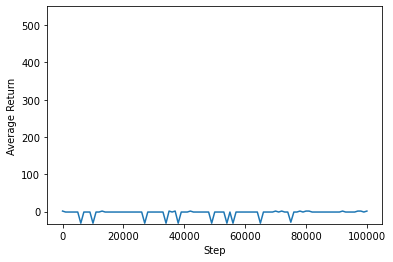

In [13]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

In [14]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [16]:
video_py_env = suite_gym.load(env_name)
video_env = tf_py_environment.TFPyEnvironment(video_py_env)

def create_policy_eval_video(policy, filename, num_episodes=50, fps=5):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = video_env.reset()
      video.append_data(video_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = video_env.step(action_step.action)
        video.append_data(video_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")